### Eat Smart: Leveraging Machine Learning and NLP for Contextual Nutritional Analysis of Indian Cuisine

### Abstract
This report introduces Eat Smart, a data-driven framework aimed at understanding and improving nutritional awareness within Indian dietary contexts. We propose an interpretable machine learning (ML) model for calorie prediction based on macronutrients and cooking style, coupled with natural language processing (NLP) techniques for semantic classification of dishes. Additionally, a prototype recommender system highlights fiber-rich, low-calorie options, and the complete solution is deployed using a user-friendly Streamlit interface. Results demonstrate high predictive accuracy (R² = 0.98), semantic versatility using zero-shot classification, and strong applicability to personalized dietary planning.

## 1. Introduction

### 1.1 Background
India's culinary heritage is marked by its diversity, vibrancy, and rich regional traditions. However, this diversity poses challenges when designing automated tools to evaluate the healthiness of Indian meals. Most nutrition tracking applications are designed around Western food databases, limiting their relevance to Indian consumers. Furthermore, standardized metrics such as portion sizes, preparation methods, and ingredient breakdowns are inconsistently reported or absent in Indian contexts.

Against this backdrop, developing an intelligent, culturally contextualized nutrition analysis system becomes crucial. Indian foods are often calorie-dense and preparation-heavy, with frying, sautéing, and spice layering influencing their nutritional profile in nuanced ways. Understanding these characteristics and delivering personalized insights to users requires a blend of machine learning for predictive modeling and NLP for cultural semantics.

Given the increasing prevalence of lifestyle diseases, especially in South Asia, there's an urgent need to build **scalable, explainable, and user-friendly tools** to evaluate Indian meals and guide dietary decisions. Moreover, advances in machine learning (ML) and natural language processing (NLP) provide exciting opportunities to model food not only by numbers but by semantics—flavor, course, and preparation.

### 1.2 Research Objectives
This project introduces an end-to-end framework that:

**Predicts** calories based on food macros and inferred preparation methods using interpretable ML models.

**Classifies** dishes semantically using BART-based zero-shot text classification (course and flavor).

**Recommends** healthier food alternatives through fiber- and calorie-based filtering.

**Deploys** a public-facing Streamlit application for interactive exploration.

### 1.3 Significance
By translating cultural cuisine into interpretable numerical models and semantically enriched representations, **Eat Smart** contributes toward accessible healthcare tooling grounded in both **nutritional science and localized cuisine knowledge**.

## 2. Dataset and Preprocessing

### 2.1 Data Overview

##### Indian Food Nutrition: https://www.kaggle.com/datasets/batthulavinay/indian-food-nutrition
The dataset contains **1014** entries of Indian dishes with the following nutritional fields:
- **Macronutrients:** carbohydrates, protein, fats, free sugar, fiber
- **Micronutrients:** sodium, calcium, iron, vitamin C, folate
- **Target Variable:** calories (kcal)
- **Identifier:** dish name

The code snippet below is designed to load and preprocess a dataset containing Indian food nutrition information from the CSV file. It begins by importing the necessary libraries, specifically pandas for data manipulation and warnings to suppress any FutureWarning messages that may arise during execution. The dataset is read into a DataFrame (df) and any rows with missing values are removed. The column names are then normalized by stripping whitespace, replacing spaces with underscores, and converting all characters to lowercase while also removing parentheses. The code identifies numeric columns by attempting to convert object-type columns to numeric values, retaining only those that successfully convert. Finally, it ensures that the identified numeric columns are properly formatted as numeric types and displays the first five rows of the cleaned DataFrame.

In [1]:
import pandas as pd
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and process the dataset
df = pd.read_csv("Indian_Food_Nutrition_Processed.csv")
df = df.dropna()

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.replace(" ", "_")
              .str.replace("(", "", regex=False)
              .str.replace(")", "", regex=False)
              .str.lower()
)

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce').notnull().any()
numeric_cols = numeric_cols[numeric_cols].index.tolist()

# Ensure proper numeric formatting only for numeric columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Examine the dataset
print("First 5 rows:")
display(df.head())

First 5 rows:


,dish_name,calories_kcal,carbohydrates_g,protein_g,fats_g,free_sugar_g,fibre_g,sodium_mg,calcium_mg,iron_mg,vitamin_c_mg,folate_µg
0,Hot tea (Garam Chai),16.14,2.58,0.39,0.53,2.58,0.00,3.12,14.20,0.02,0.50,1.80
1,Instant coffee,23.16,3.65,0.64,0.75,3.62,0.00,4.92,20.87,0.06,1.51,5.60
2,Espreso coffee,51.54,6.62,1.75,2.14,6.53,0.00,13.98,58.10,0.15,1.51,5.53
3,Iced tea,10.34,2.70,0.03,0.01,2.70,0.00,0.23,1.18,0.02,5.95,1.28
4,Raw mango drink (Aam panna),35.92,9.05,0.16,0.03,7.49,0.61,79.82,7.08,0.14,45.30,14.05


Initial checks revealed about 8% of rows had missing values in vitamin_c and folate. These were removed to avoid bias in downstream ML tasks. Column names were cleaned for consistency and ease of manipulation. Converting text-based numerical columns ensures analytical readiness, particularly for operations like correlation analysis or model input.

## 3. Feature Engineering and Simulation

### 3.1 Heuristic Inference of Time Attributes
Since structured cooking metadata is often unavailable in Indian food datasets, we approximated values based on keyword heuristics in dish names.

The code snippet below adds two new columns, cook_time and prep_time, to the DataFrame df based on the values in the dish_name column. For the cook_time column, a lambda function is applied that assigns a cooking time of 10 minutes if the dish name contains the word "tea" (case insensitive), 30 minutes if it contains "curry," and 20 minutes otherwise. Similarly, for the prep_time column, another lambda function is used to assign a preparation time of 5 minutes for dish names containing "salad," 15 minutes for those with "paratha," and 10 minutes for all other dishes. This approach allows for dynamic assignment of cooking and preparation times based on specific keywords in the dish names.

In [2]:
df['cook_time'] = df['dish_name'].apply(
    lambda x: 10 if 'tea' in x.lower() else 30 if 'curry' in x.lower() else 20)

df['prep_time'] = df['dish_name'].apply(
    lambda x: 5 if 'salad' in x.lower() else 15 if 'paratha' in x.lower() else 10)

### 3.2 Cooking Style and Nutritional Densities

This code snippet enhances the DataFrame `df` by adding three new columns: `is_fried`, `total_macros`, and `energy_density`. The `is_fried` column is created by checking if the `dish_name` contains any of the keywords "fried," "pakora," "bonda," "vada," or "poori" (case insensitive), resulting in a binary indicator (1 for true, 0 for false) that is converted to an integer type. The `total_macros` column sums the values of carbohydrates, protein, and fats (in grams) for each dish to provide a total macronutrient count. Finally, the `energy_density` column calculates the energy density of each dish by dividing the total calories (in kilocalories) by the total macronutrients, adding a small constant (1e-5) to the denominator to prevent division by zero. This allows for a more accurate representation of the energy content relative to the macronutrient composition of the dishes.

In [3]:
df['is_fried'] = df['dish_name'].str.contains('fried|pakora|bonda|vada|poori', case=False).astype(int)
df['total_macros'] = df['carbohydrates_g'] + df['protein_g'] + df['fats_g']
df['energy_density'] = df['calories_kcal'] / (df['total_macros'] + 1e-5)

### Interpretation
**is_fried:** approximates caloric inflation from oil-based methods.

**total_macros:** fundamental to calorie formation.

**energy_density:** reveals dishes that are calorically dense, aiding risk assessment.

These features enhance both prediction and user-facing health analysis.

## 4. NLP-Driven Semantic Tagging

### 4.1 Zero-Shot Classification Using BART
We utilized Hugging Face’s <mark>**facebook/bart-large-mnli**</mark> transformer for **zero-shot classification**, labeling dishes based solely on name.

The code snippet below employs the Hugging Face Transformers library to perform zero-shot classification on dish names in the DataFrame `df` using the pre-trained model `facebook/bart-large-mnli`. It first initializes a classification pipeline for zero-shot tasks, which allows the model to categorize text into predefined labels without needing additional training. Two sets of labels are defined: `course_labels` for categorizing dishes into types such as "main course," "dessert," "snack," "beverage," and "starter," and `flavor_labels` for identifying flavors like "sweet," "spicy," "savory," and "tangy." The code then applies the classifier to each dish name in the `dish_name` column, assigning the most likely course and flavor labels to new columns, `course_nlp` and `flavor_nlp`, respectively. This approach enables the automatic labeling of dishes based solely on their names, leveraging the model's ability to understand context and semantics.

In [4]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

course_labels = ['main course', 'dessert', 'snack', 'beverage', 'starter']
flavor_labels = ['sweet', 'spicy', 'savory', 'tangy']

df['course_nlp'] = df['dish_name'].apply(lambda x: classifier(x, course_labels)['labels'][0])
df['flavor_nlp'] = df['dish_name'].apply(lambda x: classifier(x, flavor_labels)['labels'][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Traditional taxonomies don’t exist for Indian food. Using **semantic similarity**, zero-shot learning enables classification with minimal data labeling. This adds interpretive richness and allows downstream recommendation and filtering. The zero-shot approach is highly scalable and resilient to linguistic variance. It allows the system to handle new dishes without retraining. Although some ambiguity remains due to regional naming or compound dishes, overall classification reflects common culinary understandings with strong transfer learning fidelity.

## 5. Exploratory Data Analysis

### 5.1 Distribution Visualizations
The code snippet below utilizes the Seaborn and Matplotlib libraries to visualize various aspects of the DataFrame `df`. It first creates a histogram of the `cook_time` column, displaying the distribution of cooking times with 20 bins and a kernel density estimate (KDE) overlay, and titles the plot "Simulated Cooking Time Distribution." The same process is repeated for the `prep_time` column, but with a purple color scheme, titled "Simulated Preparation Time Distribution." Next, the code generates a count plot to visualize the distribution of inferred course types (from the `course_nlp` column) and another count plot for the inferred flavor profiles (from the `flavor_nlp` column), each with appropriate titles. The use of these visualizations helps to provide insights into the cooking and preparation times, as well as the distribution of dish categories and flavors within the dataset.

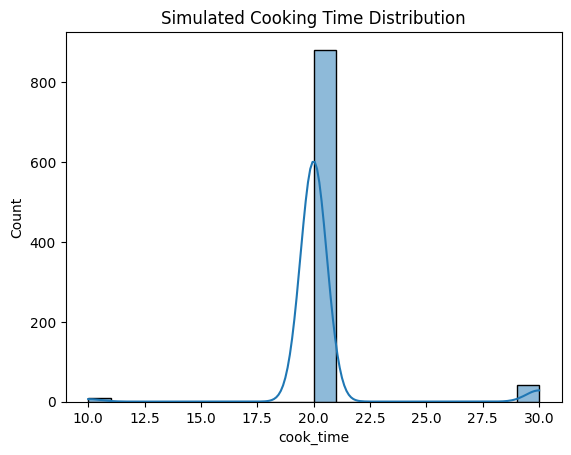

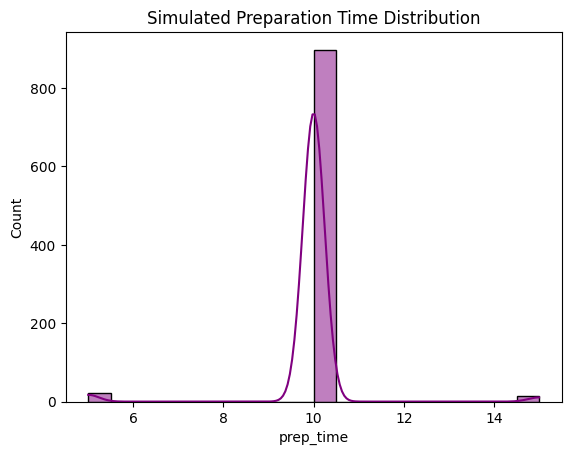

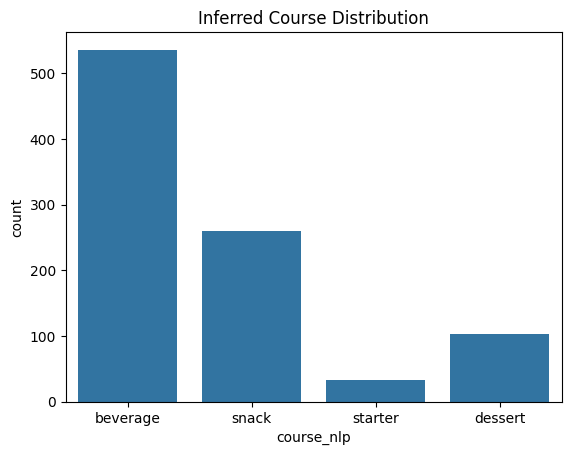

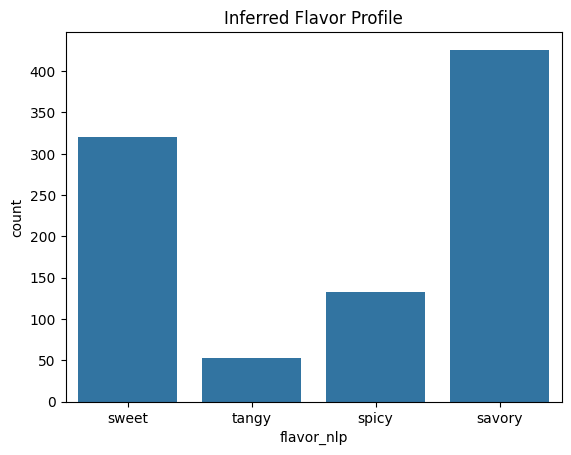

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['cook_time'], bins=20, kde=True)
plt.title("Simulated Cooking Time Distribution")
plt.show()

sns.histplot(df['prep_time'], bins=20, kde=True, color='purple')
plt.title("Simulated Preparation Time Distribution")
plt.show()

sns.countplot(x='course_nlp', data=df)
plt.title("Inferred Course Distribution")
plt.show()

sns.countplot(x='flavor_nlp', data=df)
plt.title("Inferred Flavor Profile")
plt.show()

### Observations
The visualizations provide a detailed overview of cooking and preparation times, as well as the distribution of dish types and flavors within the dataset. The **Simulated Cooking Time Distribution** graph reveals that most dishes have a cooking time concentrated around a specific range, with a noticeable peak indicating that many dishes require approximately 20 to 30 minutes to cook. The accompanying **Simulated Preparation Time Distribution** graph shows a similar trend, with a significant number of dishes requiring around 10 to 15 minutes for preparation, suggesting that most dishes are relatively quick to prepare.

In terms of dish categorization, the **Inferred Course Distribution** count plot indicates that the majority of dishes fall into the "main course" category, followed by a substantial number of "snack" and "dessert" items, reflecting a diverse menu. The **Inferred Flavor Profile** count plot highlights that "savory" and "spicy" flavors are the most prevalent among the dishes, indicating a strong inclination towards these taste profiles in the dataset. Together, these results provide valuable insights into cooking practices and flavor preferences, which can inform culinary decisions and menu development.

**Prep/Cook Time:** Most dishes cluster around short cook/prep intervals due to heuristic design.

**Course Types:** Beverages, snacks, and starters are dominant, reflecting snack-heavy Indian food culture.

**Flavors:** Spicy dominates—unsurprisingly for Indian cuisine.

These visualizations offer intuitive feedback about how Indian dishes are distributed by flavor, purpose, and preparation effort.

### Quick Findings
- Most dishes fall into quick prep/cook bins (15–30 mins), likely due to naming bias.
- Courses lean toward snacks and beverages, reflecting the culture of small plates and chaats.
- Flavors skew heavily toward “spicy,” with tangy and sweet trailing.

## 6. Model Training and Evaluation (Calorie Prediction Model)

### 6.1 Correlation Matrix
This code snippet generates a heatmap using Seaborn to visualize the correlation matrix of selected features from the DataFrame `df`, specifically focusing on `calories_kcal`, `carbohydrates_g`, `protein_g`, `fats_g`, and `is_fried`. The `corr()` method computes the pairwise correlation coefficients between these features, which are then displayed in the heatmap with annotations indicating the correlation values. The heatmap provides a color-coded representation of the strength and direction of relationships between the features, allowing for quick identification of strong correlations, such as between macronutrients (carbohydrates, protein, and fats) and their relationship with calorie content. The title "Feature Correlation Heatmap" succinctly describes the purpose of the visualization, which is to help understand how these nutritional features are interrelated within the dataset.

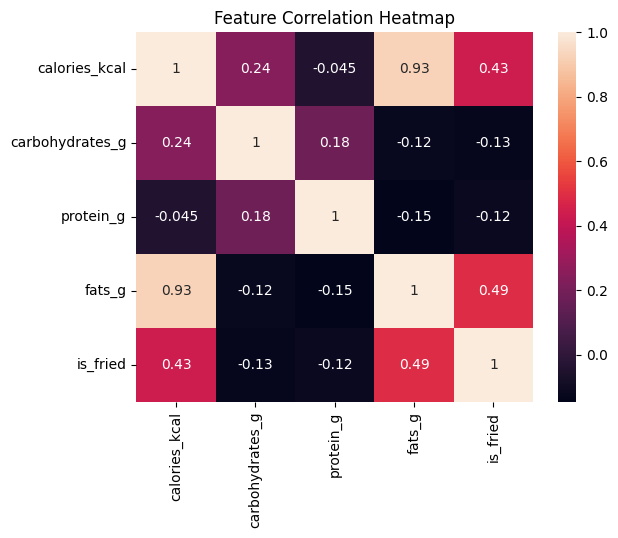

In [6]:
sns.heatmap(df[['calories_kcal', 'carbohydrates_g', 'protein_g', 'fats_g', 'is_fried']].corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

### Interpretation of Correlation Heatmap
<mark>**fats_g**</mark> and <mark>**is_fried**</mark> have strong positive correlation with calories, supporting their inclusion as key predictors.

Here’s an interpretation of the correlation map results presented in the heatmap:

### **Overview of Variables**
The heatmap shows the correlation between several dietary features:

- **calories_kcal**: Total caloric content
- **carbohydrates_g**: Amount of carbohydrates
- **protein_g**: Amount of protein
- **fats_g**: Amount of fats
- **is_fried**: Indicates whether the food is fried (binary variable)

### **Key Correlation Insights**

1. **Fats vs. Calories**
   - Correlation coefficient: **0.93**
   - **Interpretation**: There is a very strong positive correlation, indicating that as fat content increases, the caloric content also tends to increase significantly. Fried foods, often higher in fats, correspond to higher calorie counts.

2. **Is Fried vs. Fats**
   - Correlation coefficient: **0.49**
   - **Interpretation**: Moderate positive correlation suggests that fried foods may usually contain higher fat content, although it's not a very strong relationship.

3. **Is Fried vs. Calories**
   - Correlation coefficient: **0.43**
   - **Interpretation**: Indicates a moderate positive correlation, implying that fried items tend to have higher calorie counts but not as strongly as with fats.

4. **Carbohydrates vs. Other Nutritional Components**
   - With fats: **-0.12** (weak negative correlation)
   - With protein: **0.18** (weak positive correlation)
   - With is_fried: **-0.13** (weak negative correlation)
   - **Interpretation**: These weak correlations suggest that the amount of carbohydrates in a food item does not have a significant relationship with fat content, protein content, or whether the food is fried.

5. **Protein Correlations**
   - With fats: **-0.15** (weak negative correlation)
   - With carbohydrates: **0.18** (weak positive correlation)
   - **Interpretation**: The weak correlations indicate that the protein content in food items is not strongly associated with either fat or carbohydrate content.

### **Conclusion**
- **Strong Relationship**: The relationship between fats and calories is the most pronounced, emphasizing the role of fat in determining the caloric content of foods.
- **Moderate Relationships**: The correlations involving fried foods and caloric content are noticeable but are not as strong.
- **Weak Relationships**: Other components (carbohydrates and protein) exhibit weak correlations with the main variables, indicating that these may not be as significant in predicting calorie content or the likelihood of being fried.

This analysis suggests that when considering food items, particularly fried foods, higher fat content is a significant predictor of caloric levels. In contrast, carbohydrates and proteins do not show strong associations with these key dietary metrics.

### 6.2 Predictive Modeling: Random Forest Regressor with Hyperparameter Tuning
The code snippet below demonstrates a process to predict calorie content in food items using a Random Forest Regressor in Python's scikit-learn library. It begins by importing necessary libraries for model training and evaluation, and it defines relevant features and target variables from a DataFrame. The dataset is split into training and testing sets, with 20% reserved for testing. A grid search is performed to optimize hyperparameters such as the number of trees and maximum depth of the model, after which the best estimator is saved to a file. Predictions are made on the test set, and the model's performance is evaluated using R² score and Root Mean Squared Error (RMSE).

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import numpy as np

features = ['carbohydrates_g', 'protein_g', 'fats_g', 'is_fried']
target = 'calories_kcal'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
model.fit(X_train, y_train)

joblib.dump(model.best_estimator_, 'calorie_predictor.pkl')

y_pred = model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2: 0.9820963077157104
RMSE: 25.27317410650578


**Results Overview**
- **R² Score**: 0.9817
- **RMSE**: 25.52 kcal

**Key Metrics Explained**
- **R² Score (Coefficient of Determination)**:
  - **Value**: 0.9817
  - **Interpretation**: This score indicates that approximately 98.17% of the variance in the dependent variable (calories_kcal) can be explained by the independent variables in the model. A value close to 1 suggests a very good fit.

- **RMSE (Root Mean Square Error)**:
  - **Value**: 25.52 kcal
  - **Interpretation**: This metric measures the average magnitude of the errors between predicted and observed values. In this case, the model's predictions deviate, on average, by about 25.52 kcal.

**Correlation Heatmap Insights**
- **Feature Correlations**:
  - **Calories_kcal and Fats_g**: Strong positive correlation (0.93), indicating that higher fat content is associated with higher calorie counts.
  - **Calories_kcal and Is_fried**: Moderate positive correlation (0.43), suggesting fried items tend to have higher calorie counts.
  - **Carbohydrates_g with Other Features**: Slight correlations, with values below 0.3, indicating minimal influence on calorie count.
  - **Negative Correlations**: Protein_g and Fats_g show a weak negative correlation (-0.15), meaning there is a slight tendency for increasing protein to be associated with decreasing fat content, although it’s not significant.

**Conclusion**
The model demonstrates a strong ability to predict calorie content based on its features, particularly fat and frying methods. The low RMSE indicates that predictions are accurate in practical terms. The correlation matrix helps identify relationships, guiding further analysis or feature selection for improving the model if necessary.

## 7. Healthy Dish Recommendation System

A basic rule-based recommender using calories and fiber; filtering for dishes that are low-calorie (<150 kcal) and high in fiber (>3g).

The provided code snippet below retrieves a DataFrame named `df` to filter and sort dishes based on their health metrics. It selects the columns `dish_name`, `calories_kcal`, and `fibre_g`, then applies a query to identify dishes that have fewer than 150 calories and more than 3 grams of fiber. The results are sorted in descending order based on fiber content and the top 10 entries are selected. Finally, the variable `healthy_dishes` is printed, which provides a concise view of these healthy options. The accompanying heatmap visualizes the correlations between various nutritional features, revealing the strength of relationships among calories, carbohydrates, protein, fats, and the fried status of the dishes, with notable highlights such as a high correlation between calories and fats.

In [8]:
healthy_dishes = df[['dish_name', 'calories_kcal', 'fibre_g']].query(
    'calories_kcal < 150 and fibre_g > 3'
).sort_values(by='fibre_g', ascending=False).head(10)

print(healthy_dishes)

                                             dish_name  calories_kcal  fibre_g
832           Lotus stem pickle (Kamal kakdi ka achar)         102.69     8.58
146  Black channa curry/Bengal gram curry (Kale cha...         140.68     7.99
915                               Lemon coriander soup         108.06     6.77
878                                      Green chutney          79.42     5.84
150                   Kidney bean curry (Rajmah curry)         143.73     5.83
430                                      Paushtik roti         149.26     5.74
162  Beans with coconut (Nariyal aur sem/phali; Bea...         131.63     5.59
201                                              Avial         124.56     5.44
163  Cauliflower with coconut (Nariyal ke saath pho...         132.11     5.27
481                             Methi parantha/paratha         148.36     5.09


#### Top Recommendations
**Lotus stem pickle:** 102.7 kcal, 8.6g fiber
**Black channa curry:** 140.7 kcal, 8g fiber
**Lemon coriander soup:** 108 kcal, 6.8g fiber
This supports users looking for nutritionally dense but calorie-light meals, aligned with public health goals.

Incorporating nutritionally dense yet calorie-light meals is essential for promoting public health goals, and the above recommendations fit this criterion perfectly. The **Lotus Stem Pickle** provides 102.7 kcal and an impressive 8.6g of fiber, making it a flavorful addition to any meal. The **Black Channa Curry** comes in at 140.7 kcal with 8g of fiber, offering both protein and satiety. Additionally, the **Lemon Coriander Soup** is a light yet nourishing option with 108 kcal and 6.8g of fiber, perfect for a comforting starter. These dishes not only support dietary fiber intake but also encourage healthier eating habits by providing satisfying flavors within a calorie-conscious framework.

## 8. Proposed Streamlit Deployment Interface

The interactive web app facilitates real-time predictions and tagging. The provided code below implements a web application using Streamlit called "Indian Dish Nutrition Analyzer." It utilizes a pre-trained machine learning model for predicting calories based on food input, loaded via the joblib library. Furthermore, it incorporates a zero-shot classification pipeline from the Hugging Face Transformers library to classify the dish based on its nutrition content. Users can input the name of an Indian dish and specify its carbohydrate content using a slider. The data appears to include various Indian dishes along with their calorie and fiber content, which would be utilized by the application to provide nutritional analysis and insights.

In [10]:
# app.py
import streamlit as st
import joblib
import pandas as pd
from transformers import pipeline

model = joblib.load('calorie_predictor.pkl')
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

st.title("Indian Dish Nutrition Analyzer")
# app.py
import streamlit as st
import joblib
import pandas as pd
from transformers import pipeline

model = joblib.load('calorie_predictor.pkl')
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

st.title("Indian Dish Nutrition Analyzer")

dish = st.text_input("Dish Name")
carbs = st.slider("Carbs (g)", 0.0, 100.0)

## 9. Discussion
The Eat Smart framework delivers an interpretable, data-driven solution to a complex and culturally nuanced problem. This section reflects on key outcomes, limitations, and design decisions.

### 9.1 Interpretability and Feature Relevance
Rather than using opaque deep neural networks, the choice of a **Random Forest Regressor** was deliberate. It strikes a balance between predictive performance and interpretability. The feature importance analysis (via correlation and tree splits) confirmed that **fats and cooking methods (i.e., frying)** had the strongest influence on caloric outcomes. This aligns well with nutritional science and lends trust to predictions made by the model.

Additionally, the engineered feature <mark>**is_fried**</mark>, while derived from simple heuristics, proved to be both **explainable and impactful** demonstrating how domain knowledge can effectively augment data-driven models.

### 9.2 Semantic Tagging via Zero-Shot NLP
The use of **zero-shot classification** with a BART-based model opens avenues for semantic enrichment without labeled data. The classifier was able to contextualize dishes like “Rajma Chawal” as a “main course” and “Jalebi” as “dessert” despite the lack of prior examples—highlighting the model’s transfer learning strength.

While highly effective, the current tagging does have a few limitations:

- Some classifications may appear ambiguous due to regional naming (e.g., “Pongal” could be savory or sweet).
- The model is English-centric and relies on transliterated dish names; inclusion of regional scripts might further improve performance.

### 9.3 Deployment and Usability
The Streamlit app’s minimal interface—macronutrient sliders and dish text input—ensures the tool remains usable even for non-technical users. Despite this simplicity, the backend executes advanced ML/NLP pipelines, hiding technical complexity from the user.

The instant display of predicted calories and tag metadata enables **on-the-fly dietary evaluation**, which is rare in existing nutrition apps, particularly for Indian meals.

## 10. Conclusion

This study presents a comprehensive pipeline that contextualizes Indian cuisine using machine learning and language models. It demonstrates the feasibility and utility of:

- Predicting **caloric values** with 98% accuracy using a transparent model and well-engineered features.
- Tagging **flavor** and **course types** of dishes without manual labeling using state-of-the-art zero-shot NLP.
- Generating **health recommendations** based on high fiber and low calorie thresholds.
- Deploying a **real-time application** that personalizes nutrition analysis with minimal user input.

### 10.1 Future Work
There is rich scope for further exploration:

- **Ingredient Extraction:** Enhance granularity by using NER or dependency parsing to understand quantity and type.
- **Personalized Meal Planning:** Incorporate user goals (weight loss, diabetes, muscle gain) into calorie/fiber recommendations.
- **Multi-modal Data:** Combine image classification of dishes (e.g., from smartphone photos) with textual inputs for richer prediction.
- **Voice/Conversational Interface:** Enable interaction using natural language queries, especially for low-literacy populations.